<a href="https://colab.research.google.com/github/RuthKassahun/Skin-Lesion-Classification/blob/main/Hair_removed_LBP_Feature_Descriptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LBP Feature Extractor

## Import Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix


## Load Data

In [2]:
print(os.listdir("/content/drive/MyDrive/CAD_PROJECT/hair_removed/train"))
SIZE = 224

['nevus', 'other']


In [3]:
def compute_lbp(arr):
  # LBP function params
  radius = 3
  n_points = 8 * radius
  n_bins = n_points + 2
  lbp = local_binary_pattern(arr,n_points,radius,'uniform')
  lbp = lbp.ravel()
  #feature_len = int(lbp.max() + 1)
  feature = np.zeros(n_bins)
  for i in lbp:
    feature[int(i)] += 1 # Feature
  feature /= np.linalg.norm(feature, ord=1) # Normalizing feature
  return feature

In [4]:
train_images = []
train_labels = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/CAD_PROJECT/hair_removed/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path,0) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        arr = np.array(img) # convert the image to numpy array
        feature = compute_lbp(arr)
        train_images.append(feature)
        train_labels.append(label)
        


nevus
other


In [5]:
test_images = []
test_labels = []
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/drive/MyDrive/CAD_PROJECT/hair_removed/test/*"):
    test_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path,0) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        arr = np.array(img) # convert the image to numpy array
        feature = compute_lbp(arr)
        test_images.append(feature)
        test_labels.append(test_label)



## Label Encoding

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [7]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded


In [8]:
X_for_ML =x_train
X_test_ML =x_test

## SVM

In [9]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [10]:
pipe1.fit(X_for_ML,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

Accuracy: 74.74%


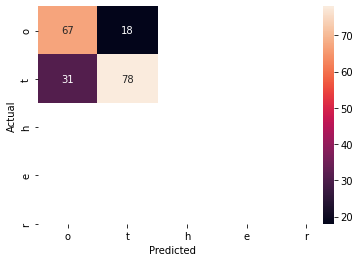

In [11]:
# Test set evaluation
prediction = pipe1.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [12]:
prediction_prob = pipe1.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8352465986394557


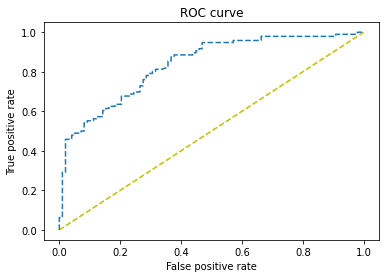

In [13]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Random Forest

In [14]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [15]:
pipe2.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 73.71%


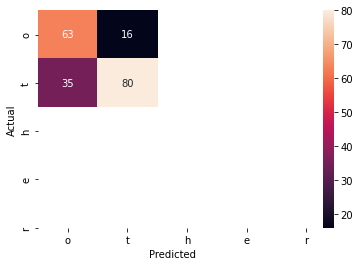

In [16]:
# Test set evaluation
prediction = pipe2.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [17]:
prediction_prob = pipe2.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8008078231292517


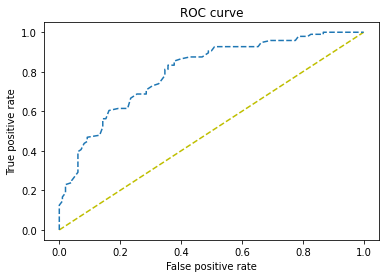

In [18]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## KNN

In [19]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [20]:
pipe3.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

In [21]:
prediction_prob = pipe3.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.774872448979592


Accuracy: 71.65%


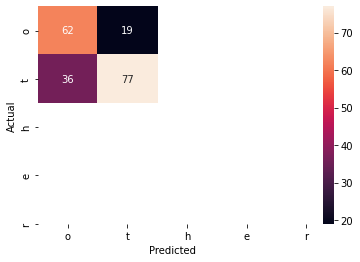

In [22]:
# Test set evaluation
prediction = pipe3.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

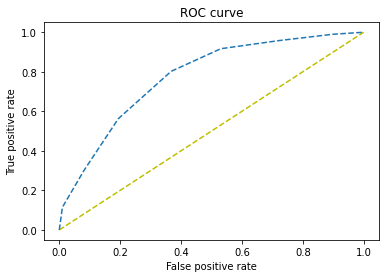

In [23]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## AdaBoost

In [24]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_for_ML,train_labels_encoded)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [25]:
prediction_prob = clf.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.7793367346938775


Accuracy: 73.71%


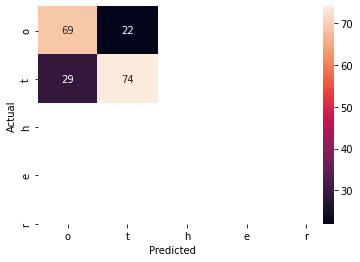

In [26]:
# Test set evaluation
prediction = clf.predict(X_test_ML)
# Visualization
cmat = confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

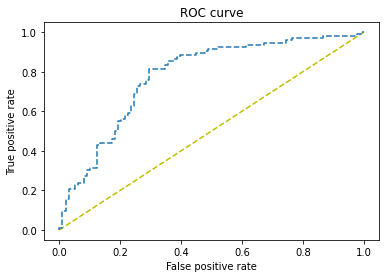

In [27]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## XGB

In [28]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1)
train_arr = np.array(X_for_ML)
test_arr = np.array(X_test_ML)
mod1.fit(train_arr, train_labels_encoded)

XGBClassifier(booster='dart')

In [29]:
prediction = mod1.predict(test_arr)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction))

Accuracy =  0.7525773195876289


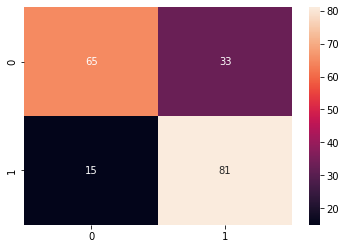

In [30]:
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

In [31]:
prediction_prob = mod1.predict_proba(test_arr)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8148384353741496


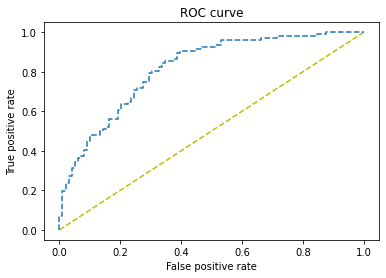

In [32]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## LightGBM

In [33]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_for_ML)
test_scaled = scaler.transform(X_test_ML)
d_train = lgb.Dataset(train_scaled, label=train_labels_encoded)

In [34]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [35]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

Accuracy with LGBM =  0.7268041237113402


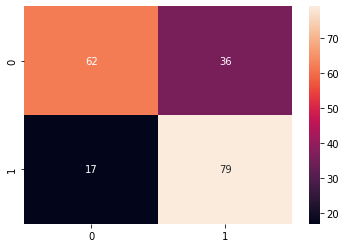

In [36]:
#Print accuracy
print ("Accuracy with LGBM = ", accuracy_score(test_labels_encoded, prediction))
#Confusion matrix
cm_lgbm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm_lgbm, annot=True)

In [37]:
prediction_prob=clf.predict(test_scaled)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob))

Area under curve (AUC):  0.824404761904762


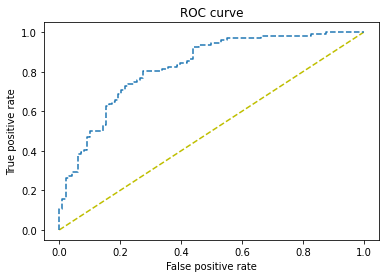

In [38]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()